In [1]:
import mininet
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

In [2]:
# ---- Data: binary Iris (classes 0 & 1) ----
iris_data = load_iris()
X = iris_data.data
y = iris_data.target
mask = y < 2
X = X[mask]
y = y[mask]                # labels in {0,1}...

# Map to {-1, 1}
y = np.where(y == 0, -1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (75, 4)
y_train shape: (75,)


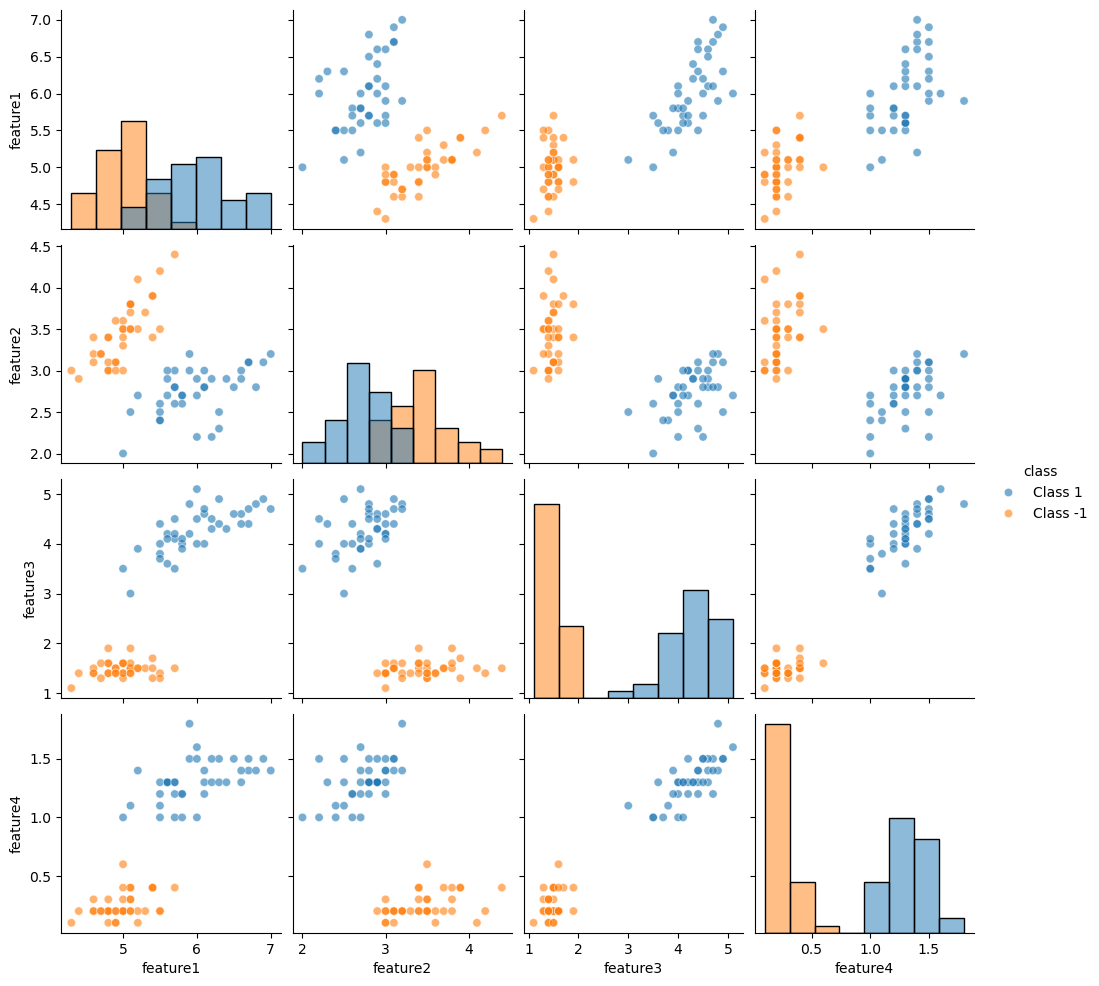

In [3]:
# ---- Pairplot ----
X_plot = pd.DataFrame(X_train, columns=['feature1','feature2','feature3','feature4'])
y_plot = pd.Series(y_train, name='class').map({-1:'Class -1', 1:'Class 1'})
df_plot = pd.concat([X_plot, y_plot], axis=1)
sn.pairplot(df_plot, hue='class', diag_kind='hist', plot_kws={'alpha':0.6})

In [4]:
# ---- Model Initialization ----
MLP = mininet.MLP(4, [16, 16, 1])
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit + transform training data
X_test_scaled = scaler.transform(X_test)

# ---- Training ----
loss_history = []
lr = 1e-3
epochs = 101

for k in range(epochs):
    # forward
    y_pred = [MLP(x) for x in X_train_scaled]  # list of Value
    # average MSE with {-1,1} targets
    loss = sum((yp - float(yt))**2 for yt, yp in zip(y_train, y_pred)) / len(y_train)
    loss_history.append(loss.data)

    # backward
    for p in MLP.parameters():
        p.grad = 0.0
    loss.backward()

    # step
    for p in MLP.parameters():
        p.data -= lr * p.grad

    if k % 5 == 0:
        print(f'EPOCH {k} | Loss: {loss.data:.6f}')

EPOCH 0 | Loss: 1.431280
EPOCH 5 | Loss: 1.193298
EPOCH 10 | Loss: 0.995791
EPOCH 15 | Loss: 0.831689
EPOCH 20 | Loss: 0.695223
EPOCH 25 | Loss: 0.581668
EPOCH 30 | Loss: 0.487132
EPOCH 35 | Loss: 0.408402
EPOCH 40 | Loss: 0.342818
EPOCH 45 | Loss: 0.288172
EPOCH 50 | Loss: 0.242632
EPOCH 55 | Loss: 0.204674
EPOCH 60 | Loss: 0.173031
EPOCH 65 | Loss: 0.146647
EPOCH 70 | Loss: 0.124646
EPOCH 75 | Loss: 0.106295
EPOCH 80 | Loss: 0.090985
EPOCH 85 | Loss: 0.078210
EPOCH 90 | Loss: 0.067547
EPOCH 95 | Loss: 0.058644
EPOCH 100 | Loss: 0.051207


In [5]:
# ---- Evaluation ----
# Continuous scores in [-1,1]; use 0 threshold for {-1,1}
y_scores = np.array([MLP(x).data for x in X_test_scaled])        # shape (n_test,)
y_pred = np.where(y_scores >= 0, 1, -1)

# For sklearn metrics that expect {0,1}, map both y_true and y_pred
y_test_bin = (y_test == 1).astype(int)
y_pred_bin = (y_pred == 1).astype(int)

cm = confusion_matrix(y_test_bin, y_pred_bin)
acc = accuracy_score(y_test_bin, y_pred_bin)
print("Accuracy:", acc)
print("Classification report:\n", classification_report(y_test_bin, y_pred_bin, digits=4))

Accuracy: 1.0
Classification report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        13
           1     1.0000    1.0000    1.0000        12

    accuracy                         1.0000        25
   macro avg     1.0000    1.0000    1.0000        25
weighted avg     1.0000    1.0000    1.0000        25



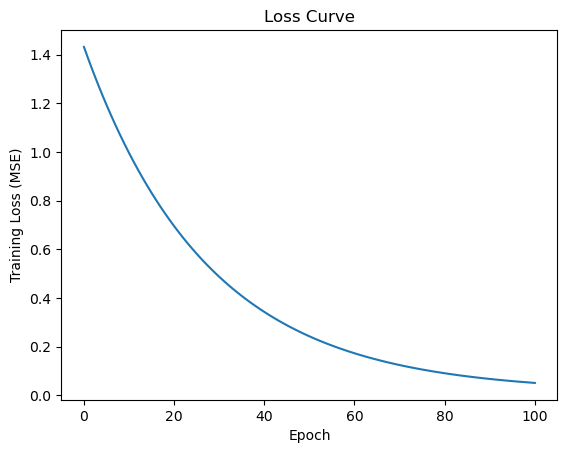

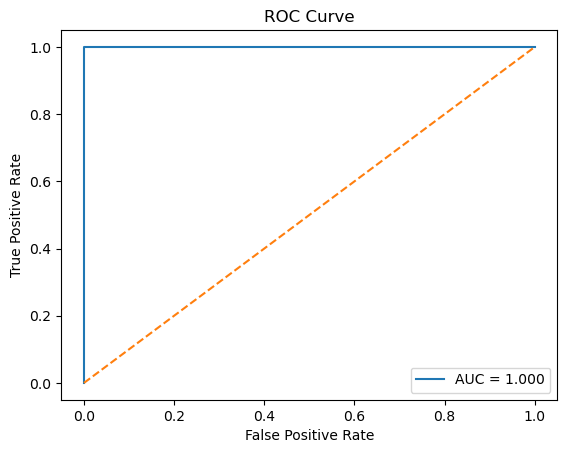

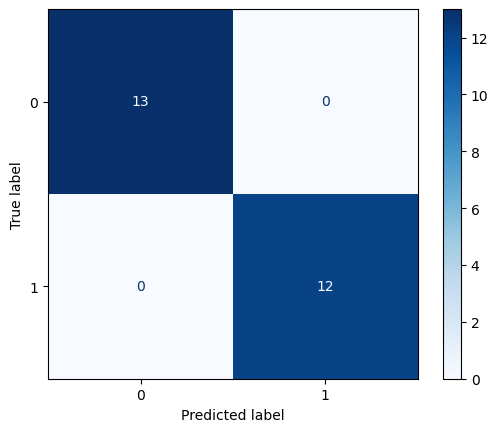

In [6]:
# ---- Plots ----
# Loss curve
plt.figure()
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Loss Curve")
plt.show()

# ROC curve
auc = roc_auc_score(y_test_bin, y_scores)
fpr, tpr, _ = roc_curve(y_test_bin, y_scores)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.show()